# Final Results

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import mixture
import json
import sys
import os
sys.path.insert(0, '..')
from database import mongo_client
from anomaly_detection import evaluation
from anomaly_detection import preprocessing as ad_pp
from anomaly_detection import GMM
from anomaly_detection import PCA
from anomaly_detection import results
%matplotlib inline
matplotlib.style.use('ggplot')
from IPython.display import display
# auto-load changes in imported modules
%load_ext autoreload
%autoreload 2

In [2]:
filename = "all_features_(B1)_2017-04-09" #30min, B1
filename = os.path.join('..', 'CSV', filename + ".csv")
B1_30 = pd.read_csv(filename, index_col=0)
B1_30.index = pd.to_datetime(B1_30.index)
B1_30_s = ad_pp.scale_robust(B1_30)

filename = "all_features_(B2)_2017-04-09" #30min, B2
filename = os.path.join('..', 'CSV', filename + ".csv")
B2_30 = pd.read_csv(filename, index_col=0)
B2_30.index = pd.to_datetime(B2_30.index)
B2_30_s = ad_pp.scale_robust(B2_30)

In [3]:
client = mongo_client.CERNMongoClient()
start_date = '2016-04-16 00:00:00.000000'
end_date = '2016-12-14 00:00:00.000000'
labeled = client.query_tagged_anomalies(start_date, end_date)
ELB = client.query_elogbook(start_date, end_date)

Fetching data for pattern MKI.ELOGBOOK_tagged from 2016-04-16 00:00:00.000000 to 2016-12-14 00:00:00.000000
Fetching data for MKI.ELOGBOOK_tagged
Fetching data for pattern MKI.ELOGBOOK_tagged from 2016-04-16 00:00:00.000000 to 2016-12-14 00:00:00.000000
Fetching data for MKI.ELOGBOOK_tagged


## PCA

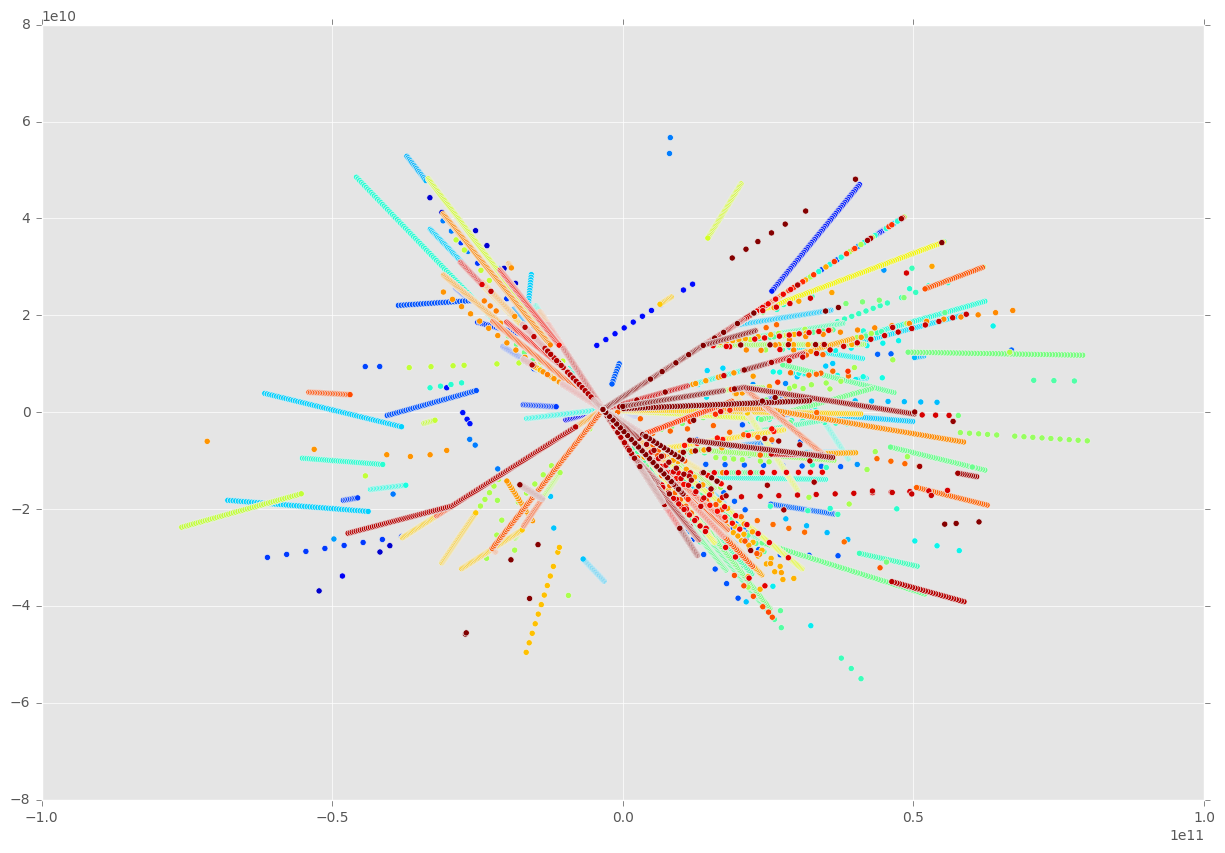

In [4]:
pca = PCA.create_pca(n_components=2)
pca_data = PCA.transform_data(B1_30_s, pca)
t = np.arange(pca_data.shape[0])
plt.figure(figsize=(15, 10))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=t)
plt.show()

In [5]:
clf_B1 = mixture.GaussianMixture(n_components=2, covariance_type='tied')
clf_B1.fit(B1_30_s)
clf_B2 = mixture.GaussianMixture(n_components=2, covariance_type='tied')
clf_B2.fit(B2_30_s)

GaussianMixture(covariance_type='tied', init_params='kmeans', max_iter=100,
        means_init=None, n_components=2, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [6]:
B1_w_probs = GMM.add_sorted_anomaly_probs(clf_B1, B1_30_s)
B2_w_probs = GMM.add_sorted_anomaly_probs(clf_B2, B2_30_s)
B1_w_probs['timestamp'] = B1_w_probs.index
B2_w_probs['timestamp'] = B2_w_probs.index

## Log prob over time

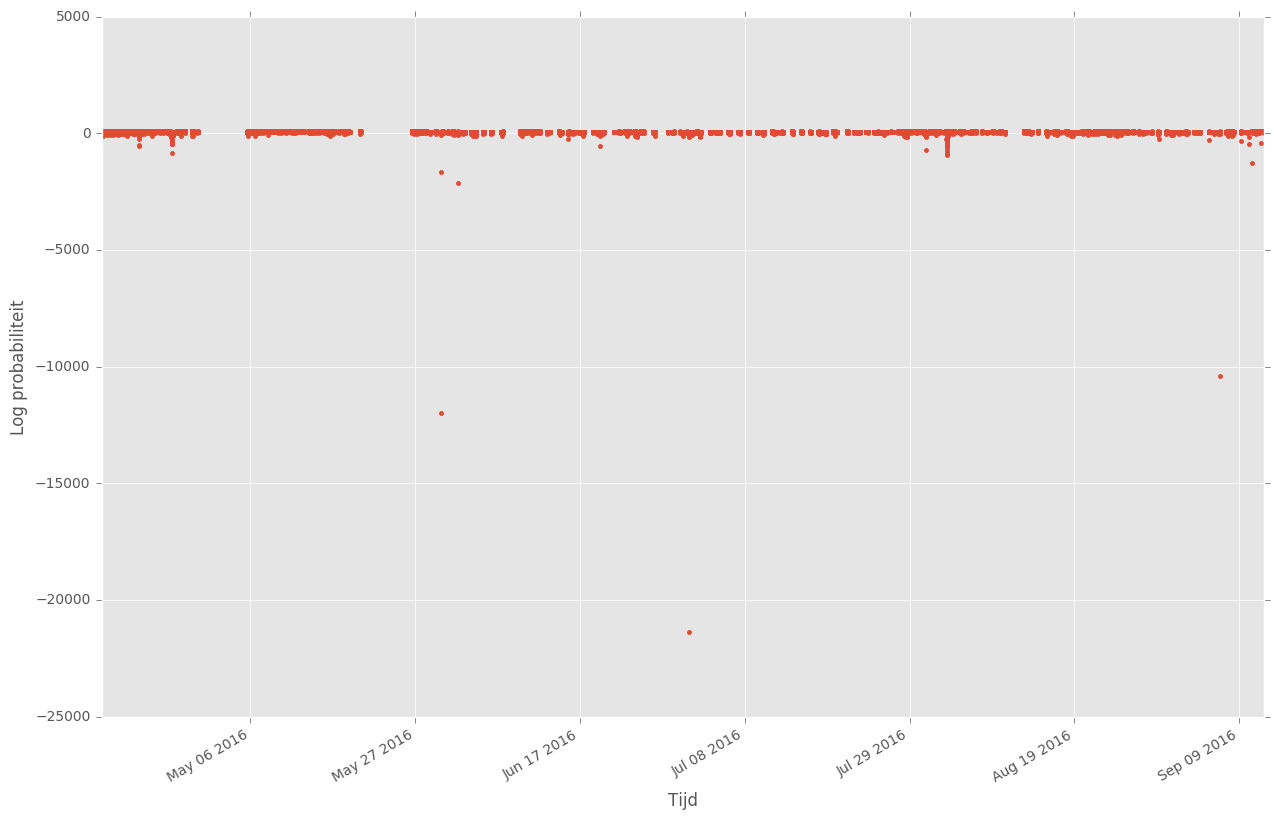

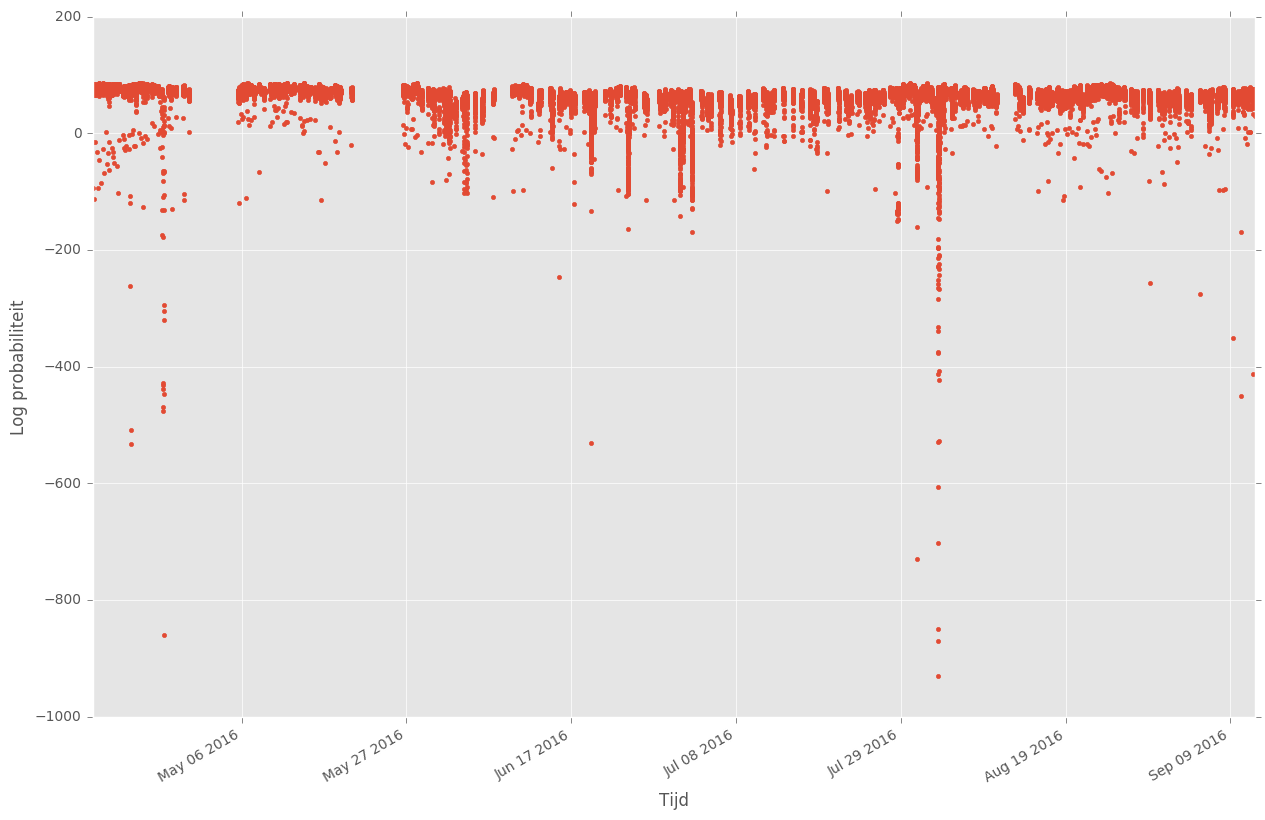

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
B1_w_probs.plot(ax=axes, x='timestamp', y='log_prob', style='.', legend=False)
axes.set_ylabel("Log probabiliteit")
axes.set_xlabel("Tijd")
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
B1_w_probs[B1_w_probs['log_prob']>-1000].plot(ax=axes, x='timestamp', y='log_prob', style='.', legend=False)
axes.set_ylabel("Log probabiliteit")
axes.set_xlabel("Tijd")
plt.show()

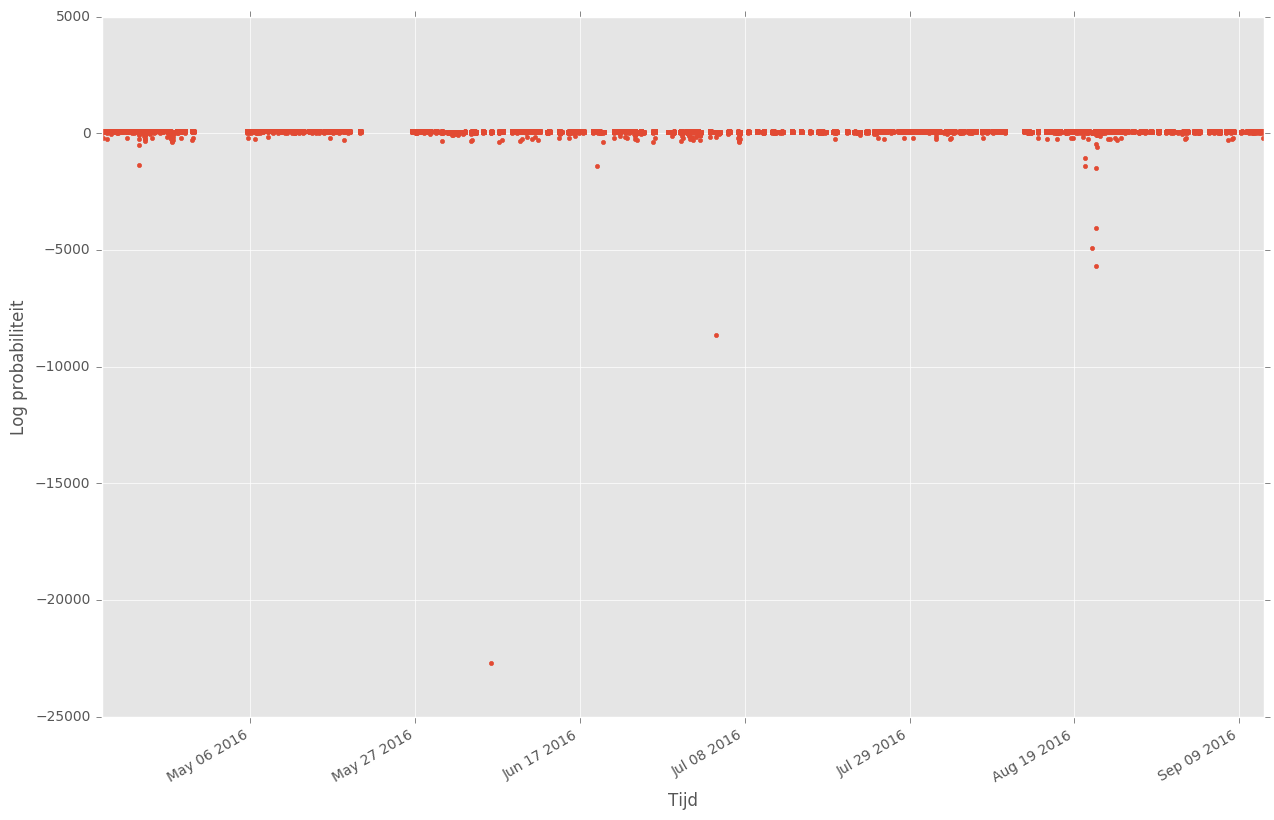

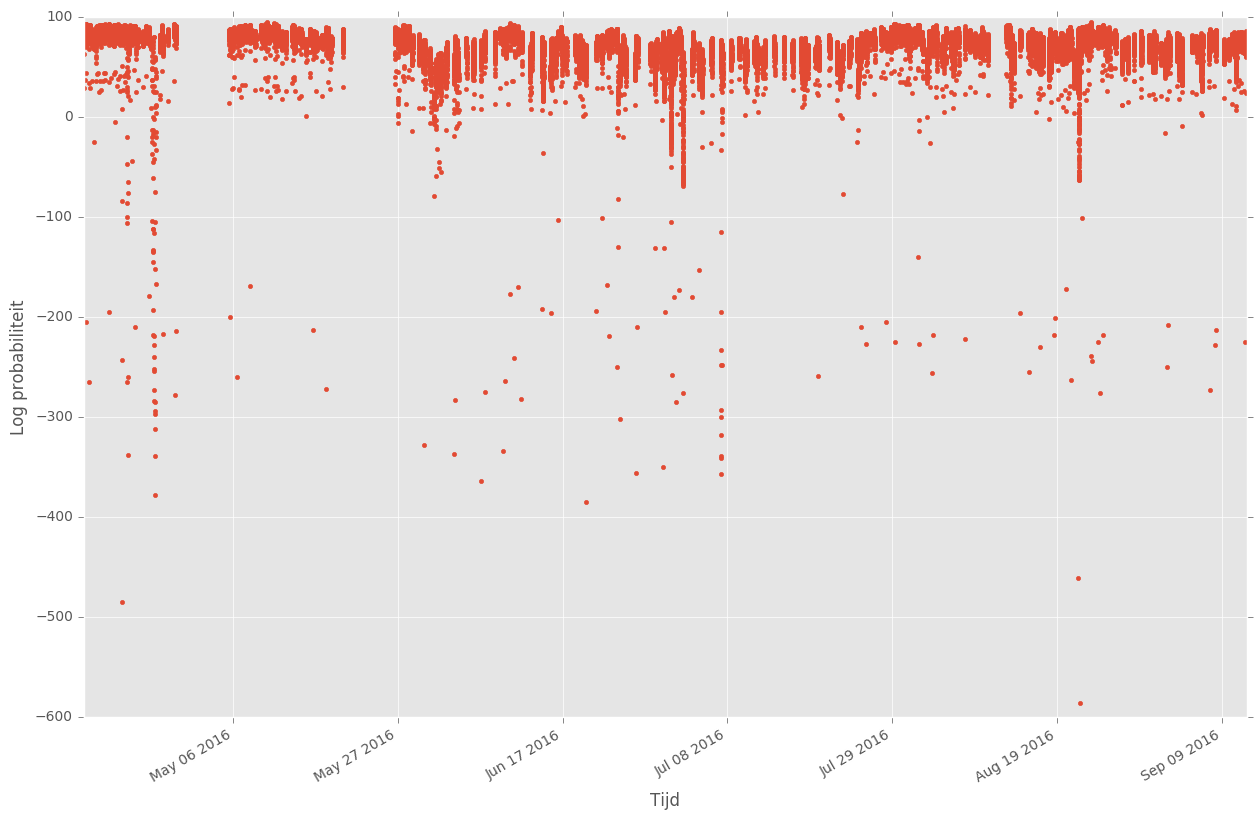

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
B2_w_probs.plot(ax=axes, x='timestamp', y='log_prob', style='.', legend=False)
axes.set_ylabel("Log probabiliteit")
axes.set_xlabel("Tijd")
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
B2_w_probs[B2_w_probs['log_prob']>-1000].plot(ax=axes, x='timestamp', y='log_prob', style='.', legend=False)
axes.set_ylabel("Log probabiliteit")
axes.set_xlabel("Tijd")
plt.show()

## Segments

In [9]:
anomaly_sizes = [100, 200, 250, 500]
segmenter = evaluation.AnomalySegmenter()
evolution_segments_B1 = list(segmenter.segments_generator(B1_w_probs, anomaly_sizes))
evolution_segments_B2 = list(segmenter.segments_generator(B2_w_probs, anomaly_sizes))

In [10]:
tables = [evaluation.compare_segmented_with_labeled(segments_B1, segments_B2, labeled)
          for segments_B1, segments_B2 in zip(evolution_segments_B1, evolution_segments_B2)]

In [11]:
# total_segmented_Bx computes the total number of anomalies in all segments for every step in the evolution
total_segmented_B1 = [sum([s.get_nb_anomalies() for s in segments_B1]) for segments_B1 in evolution_segments_B1]
total_segmented_B2 = [sum([s.get_nb_anomalies() for s in segments_B2]) for segments_B2 in evolution_segments_B2]

# total number of segments in each step
nb_segments_B1 = [len(segments_B1) for segments_B1 in evolution_segments_B1]
nb_segments_B2 = [len(segments_B2) for segments_B2 in evolution_segments_B2]

tag_totals = pd.DataFrame(ELB.groupby('VALUE')['TAG'].value_counts())
tag_totals.columns = ['Total_tags']
def count_detected(segments_B1, segments_B2, labels):
    labeled_w_detected = labels.copy()
    labeled_w_detected["detected"] = False
    for label in labeled_w_detected.index:
        ts = labeled_w_detected.loc[label, 'timestamps']
        if labeled_w_detected.loc[label, 'VALUE'] == 'MKI2':
            for segment in segments_B1:
                distance = segment.get_distance_from_ts(ts, 'start')
                if pd.Timedelta(0, unit='h') <= distance <= pd.Timedelta(12, unit='h'):
                       labeled_w_detected.loc[label, 'detected']   = True                                                
        elif labeled_w_detected.loc[label, 'VALUE'] == 'MKI8':
            for segment in segments_B2:
                distance = segment.get_distance_from_ts(ts, 'start')
                if pd.Timedelta(0, unit='h') <= distance <= pd.Timedelta(12, unit='h'):
                       labeled_w_detected.loc[label, 'detected']   = True
                        
    detected = labeled_w_detected[labeled_w_detected['detected'] == True]
    detected_totals = pd.DataFrame(detected.groupby(['VALUE', 'TAG'])['detected'].value_counts())
    detected_totals.index = detected_totals.index.droplevel(2)
    detected_totals.columns = ['Total_detected']
    return detected_totals

def count_segments_w_labels(segments_B1, segments_B2, ELB):
    ELB_relevant = ELB[ELB['TAG']!='info']
    B1_label = 0
    B1_no_label = 0
    B2_label = 0
    B2_no_label = 0
    for segment in segments_B1:
        label_found = False
        for label in ELB_relevant.index:
            ts = ELB_relevant.loc[label, 'timestamps']
            if ELB_relevant.loc[label, 'VALUE'] == 'MKI2':
                distance = segment.get_distance_from_ts(ts, 'start')
                if pd.Timedelta(0, unit='h') <= distance <= pd.Timedelta(12, unit='h'):
                    B1_label += 1
                    label_found = True
                    break
        if not label_found:
            B1_no_label += 1
    for segment in segments_B2:
        label_found = False
        for label in ELB_relevant.index:
            ts = ELB_relevant.loc[label, 'timestamps']
            if ELB_relevant.loc[label, 'VALUE'] == 'MKI8':
                distance = segment.get_distance_from_ts(ts, 'start')
                if pd.Timedelta(0, unit='h') <= distance <= pd.Timedelta(12, unit='h'):
                    B2_label += 1
                    label_found = True
                    break
        if not label_found:
            B2_no_label += 1
    return B1_label, B1_no_label, B2_label, B2_no_label

# timestamps are not unique => use event id as index
ELB2 = ELB.copy()
ELB2['timestamps'] = ELB2.index
ELB2.index = ELB2['EVENT_ID']
all_detected_totals = [tag_totals.join(count_detected(segments_B1, segments_B2, ELB2))
          for segments_B1, segments_B2 in zip(evolution_segments_B1, evolution_segments_B2)]

all_label_nolabel = [count_segments_w_labels(segments_B1, segments_B2, ELB2)
                     for segments_B1, segments_B2 in zip(evolution_segments_B1, evolution_segments_B2)]

In [12]:
for i in range(len(anomaly_sizes)):
#     display(tables[i])
    display("Number of anomalies used: {}".format(anomaly_sizes[i]))
    display("Number of anomalies in segments B1: {}".format(total_segmented_B1[i]))
    display("Number of anomalies in segments B2: {}".format(total_segmented_B2[i]))
    display("Total number of segments B1: {}".format(nb_segments_B1[i]))
    display("Total number of segments B2: {}".format(nb_segments_B2[i]))
    display("Number of segments with label B1: {}".format(all_label_nolabel[i][0]))
#     display("Number of segments without label B1: {}".format(all_label_nolabel[i][1]))
    display("Number of segments with label B2: {}".format(all_label_nolabel[i][2]))
#     display("Number of segments without label B2: {}".format(all_label_nolabel[i][3]))
    display("Precision B1: {}".format(all_label_nolabel[i][0]/float(nb_segments_B1[i])))
    display("Precision B2: {}".format(all_label_nolabel[i][2]/float(nb_segments_B2[i])))
    detected_totals = all_detected_totals[i]
    detected_totals['recall'] = detected_totals['Total_detected'] / detected_totals['Total_tags'] * 100
    detected_totals.fillna(0, inplace=True)
    idx = pd.IndexSlice
    detected_totals.sort_index(ascending=True, inplace=True)
    tbl_B1 = detected_totals.loc[idx['MKI2', ['anomaly', 'fault', 'intervention', 'research']], :]
    recall_B1 = tbl_B1['Total_detected'].sum() / float(tbl_B1['Total_tags'].sum())
    tbl_B2 = detected_totals.loc[idx['MKI8', ['anomaly', 'fault', 'intervention', 'research']], :]
    recall_B2 = tbl_B2['Total_detected'].sum() / float(tbl_B2['Total_tags'].sum())
    display("Recall B1: {}".format(recall_B1))
    display("Recall B2: {}".format(recall_B2))
    display(detected_totals)

'Number of anomalies used: 100'

'Number of anomalies in segments B1: 100'

'Number of anomalies in segments B2: 100'

'Total number of segments B1: 20'

'Total number of segments B2: 53'

'Number of segments with label B1: 6'

'Number of segments with label B2: 7'

'Precision B1: 0.3'

'Precision B2: 0.132075471698'

'Recall B1: 0.307692307692'

'Recall B2: 0.266666666667'

Total_tags  Total_detected     recall
VALUE TAG                                                
MKI2  anomaly                9             4.0  44.444444
      fault                  7             1.0  14.285714
      info                  26             2.0   7.692308
      intervention           9             3.0  33.333333
      research               1             0.0   0.000000
MKI8  anomaly                7             3.0  42.857143
      fault                 11             2.0  18.181818
      info                  22             6.0  27.272727
      intervention          10             2.0  20.000000
      research               2             1.0  50.000000

'Number of anomalies used: 200'

'Number of anomalies in segments B1: 200'

'Number of anomalies in segments B2: 192'

'Total number of segments B1: 44'

'Total number of segments B2: 64'

'Number of segments with label B1: 8'

'Number of segments with label B2: 8'

'Precision B1: 0.181818181818'

'Precision B2: 0.125'

'Recall B1: 0.384615384615'

'Recall B2: 0.3'

Total_tags  Total_detected      recall
VALUE TAG                                                 
MKI2  anomaly                9               4   44.444444
      fault                  7               1   14.285714
      info                  26               3   11.538462
      intervention           9               4   44.444444
      research               1               1  100.000000
MKI8  anomaly                7               3   42.857143
      fault                 11               3   27.272727
      info                  22               6   27.272727
      intervention          10               2   20.000000
      research               2               1   50.000000

'Number of anomalies used: 250'

'Number of anomalies in segments B1: 250'

'Number of anomalies in segments B2: 229'

'Total number of segments B1: 46'

'Total number of segments B2: 66'

'Number of segments with label B1: 8'

'Number of segments with label B2: 8'

'Precision B1: 0.173913043478'

'Precision B2: 0.121212121212'

'Recall B1: 0.384615384615'

'Recall B2: 0.3'

Total_tags  Total_detected      recall
VALUE TAG                                                 
MKI2  anomaly                9               4   44.444444
      fault                  7               1   14.285714
      info                  26               3   11.538462
      intervention           9               4   44.444444
      research               1               1  100.000000
MKI8  anomaly                7               3   42.857143
      fault                 11               3   27.272727
      info                  22               6   27.272727
      intervention          10               2   20.000000
      research               2               1   50.000000

'Number of anomalies used: 500'

'Number of anomalies in segments B1: 499'

'Number of anomalies in segments B2: 444'

'Total number of segments B1: 55'

'Total number of segments B2: 90'

'Number of segments with label B1: 8'

'Number of segments with label B2: 9'

'Precision B1: 0.145454545455'

'Precision B2: 0.1'

'Recall B1: 0.384615384615'

'Recall B2: 0.333333333333'

Total_tags  Total_detected      recall
VALUE TAG                                                 
MKI2  anomaly                9               4   44.444444
      fault                  7               1   14.285714
      info                  26               3   11.538462
      intervention           9               4   44.444444
      research               1               1  100.000000
MKI8  anomaly                7               3   42.857143
      fault                 11               4   36.363636
      info                  22               8   36.363636
      intervention          10               2   20.000000
      research               2               1   50.000000

In [13]:
display(tables[2])

nb_detected_B1  nb_segments_B1  nb_detected_B2  \
timestamps                                                            
2016-05-30 14:00:00               3               1               1   
2016-06-05 17:18:00               0               0               1   
2016-06-18 19:59:00               0               0               0   
2016-06-19 13:14:00               2               1               1   
2016-06-30 21:23:00              20               1              20   
2016-07-14 09:23:00               0               0               0   
2016-07-24 22:19:48               0               0               2   
2016-07-31 16:00:00               0               0               0   
2016-08-02 17:28:00              54               1               0   
2016-08-02 17:50:00              54               1               0   
2016-08-03 08:05:00               0               0               0   
2016-08-04 14:03:41               0               0               0   
2016-08-21 20:00:00               0               0              29   
2016-08-22 21:30:30               0               0               0   
2016-08-23 06:53:47               0               0               0   
2016-09-02 17:43:00               0               0               0   

                     nb_segments_B2         score installation  
timestamps                                                      
2016-05-30 14:00:00               1  -7039.899523         MKI8  
2016-06-05 17:18:00               1 -22724.162516         MKI8  
2016-06-18 19:59:00               0      0.000000         MKI8  
2016-06-19 13:14:00               1  -1040.305259         MKI2  
2016-06-30 21:23:00               1 -12235.537936         MKI2  
2016-07-14 09:23:00               0      0.000000         MKI8  
2016-07-24 22:19:48               1   -235.654990         MKI2  
2016-07-31 16:00:00               0      0.000000         MKI2  
2016-08-02 17:28:00               0 -14132.579868         MKI2  
2016-08-02 17:50:00               0 -14132.579868         MKI2  
2016-08-03 08:05:00               0      0.000000         MKI2  
2016-08-04 14:03:41               0      0.000000         MKI2  
2016-08-21 20:00:00               1 -13436.296725         MKI8  
2016-08-22 21:30:30               0      0.000000         MKI8  
2016-08-23 06:53:47               0      0.000000         MKI2  
2016-09-02 17:43:00               0      0.000000         MKI8

## Visual

In [14]:
ELB[ELB['TAG']!='info']
ELB_B1 = ELB[ELB['VALUE']== 'MKI2']
ELB_B2 = ELB[ELB['VALUE']== 'MKI8']

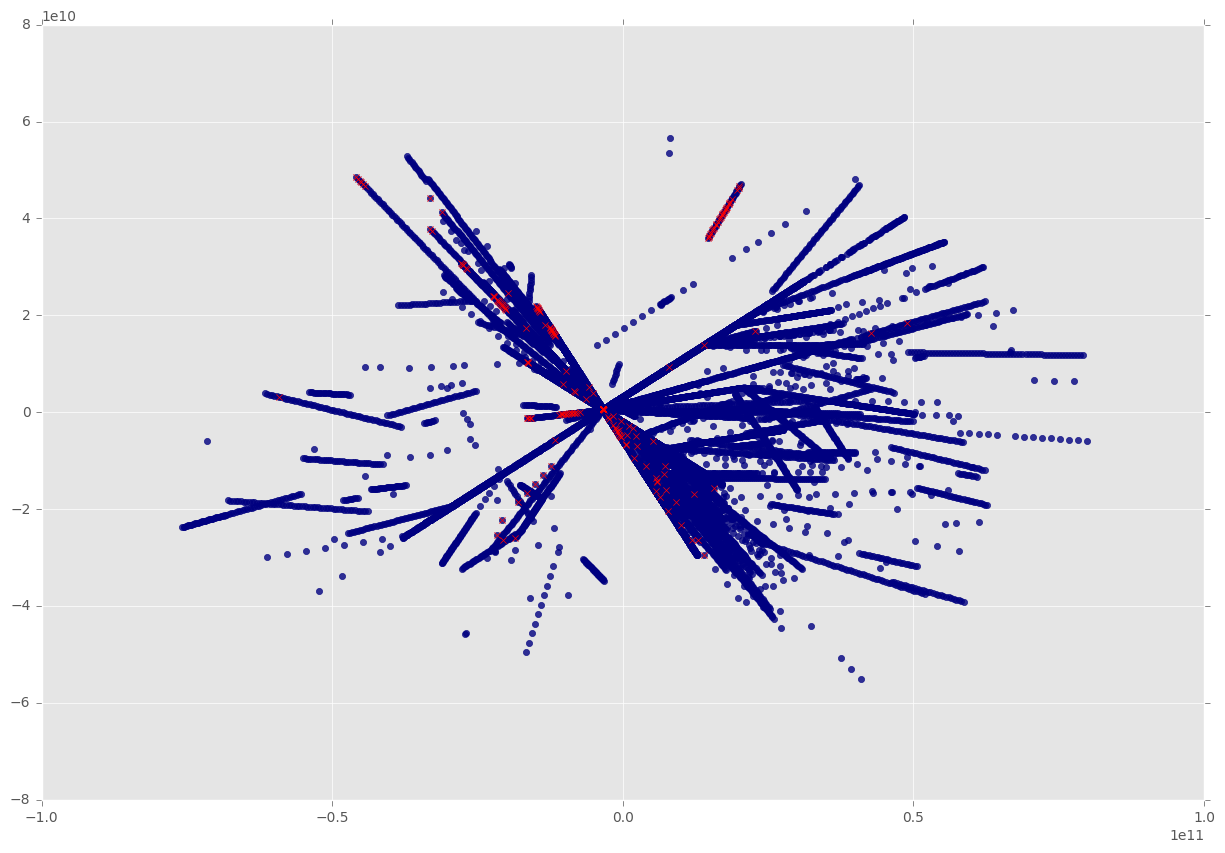

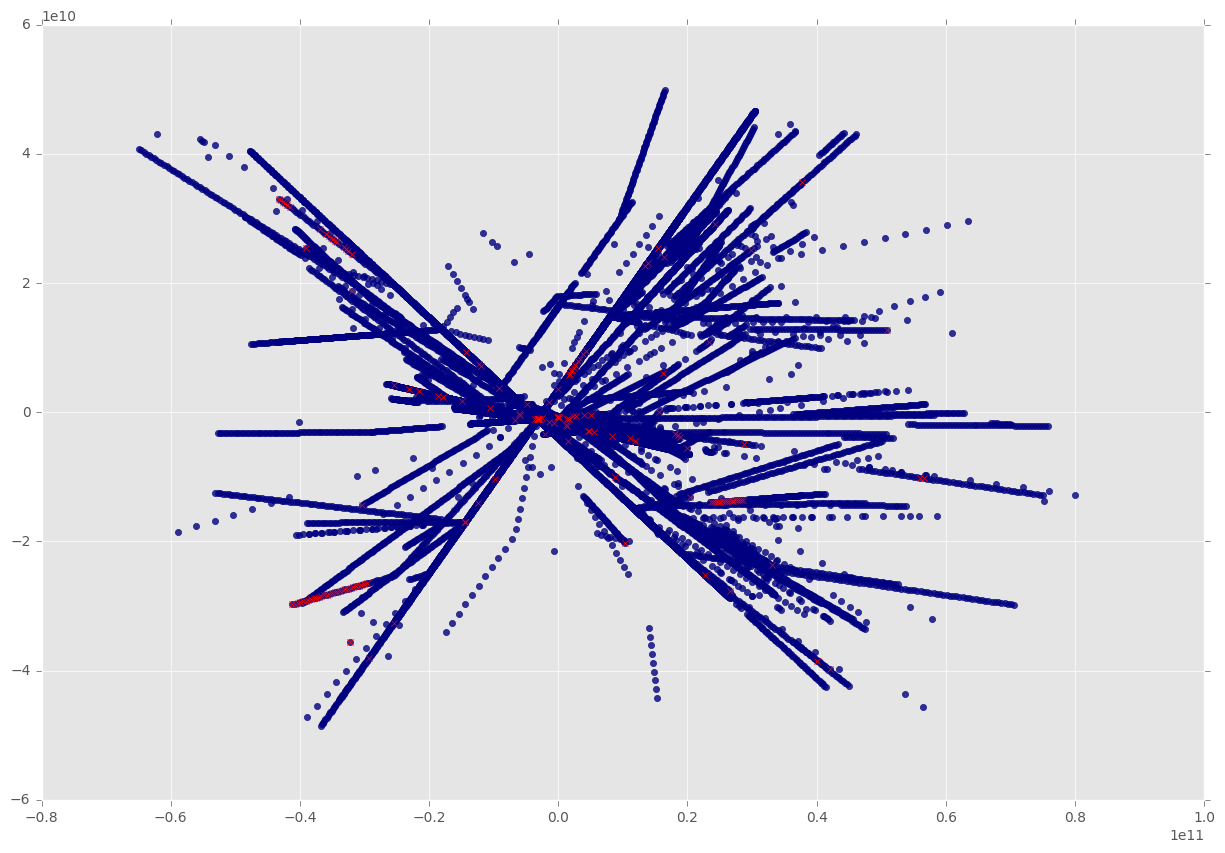

In [15]:
def plot_anomalies(data_pca, segments):
    plt.figure(figsize=(15, 10))
    plt.scatter(data_pca.iloc[:, 0], data_pca.iloc[:, 1], color='navy', alpha=.8)
    for segment in segments:
        for ts in segment.entries.index:
            plt.scatter(data_pca.loc[ts, '0'], data_pca.loc[ts, '1'], marker='x', color='red')
pca = PCA.create_pca(2)
data_pca_B1 = pd.DataFrame(data=PCA.transform_data(B1_30_s, pca), index=B1_30_s.index, columns=['0','1'])
plot_anomalies(data_pca_B1, evolution_segments_B1[2])
data_pca_B2 = pd.DataFrame(data=PCA.transform_data(B2_30_s, pca), index=B2_30_s.index, columns=['0','1'])
plot_anomalies(data_pca_B2, evolution_segments_B2[2])

In [31]:
def plot_segments_series(data, series_name, unit, segments, labels=None):
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), sharex=True)
    regex = '^MKI.*:%s$' % series_name
    timeseries = data.filter(regex=regex)
    timeseries.plot(ax=ax1, colormap='winter', kind='line', linestyle='solid')

    ax2_title = "Gedetecteerde segmenten"
    if labels is not None:
        for label in labels.index:
            ax2.axvline(label, ymin=0, ymax=0.3, color='green')
        ax2_title = "Gedetecteerde segmenten (rood) en labels (groen)"

    segment_centers = [segment.get_mean_ts() for segment in segments]
    X = -1 * np.array([segment.get_score() for segment in segments])
    X_std = (X - X.min()) / (X.max() - X.min())
    segment_scores = X_std * (1 - 0.31) + 0.31

    for center, score in zip(segment_centers, segment_scores):
        plt.axvline(center, ymin=0.3, ymax=score, color='red')
        # plt.text(center, 1, score, rotation='vertical')
    ax1.set_title(series_name)
    ax1.set_ylabel(u"{0} in {1}".format(series_name, unit))
    ax2.yaxis.set_visible(False)
    ax2.set_title(ax2_title)

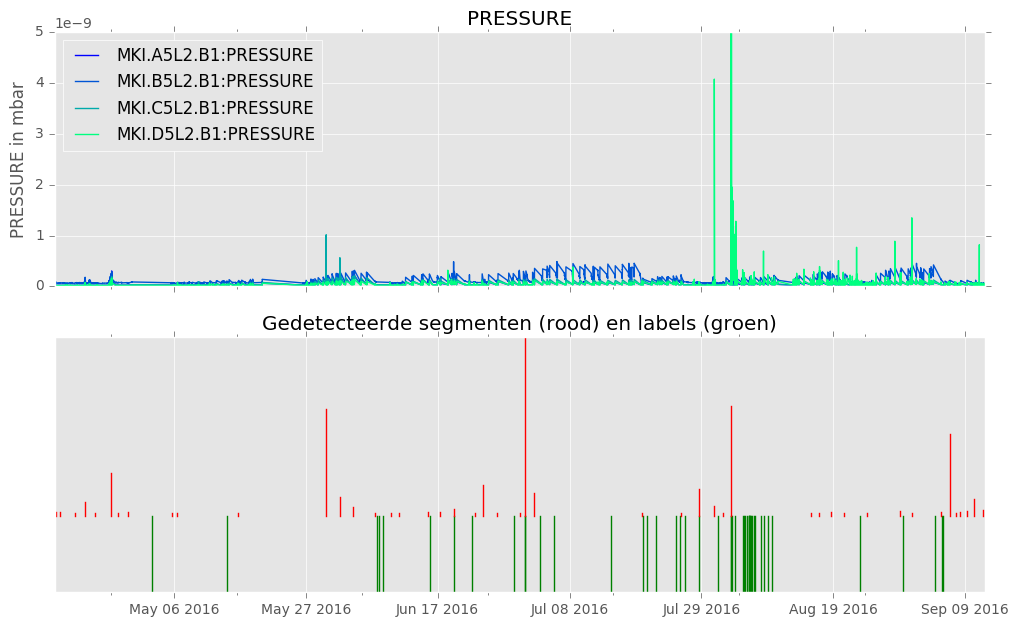

In [32]:
plot_segments_series(B1_30, "PRESSURE", "mbar", evolution_segments_B1[2], ELB_B1)

In [18]:
intensity = client.query_resample("LHC.BCTFR.A6R4.B1:BEAM_INTENSITY", start_date, end_date, '30T')

Fetching data for pattern LHC.BCTFR.A6R4.B1:BEAM_INTENSITY from 2016-04-16 00:00:00.000000 to 2016-12-14 00:00:00.000000
Fetching data for LHC.BCTFR.A6R4.B1:BEAM_INTENSITY


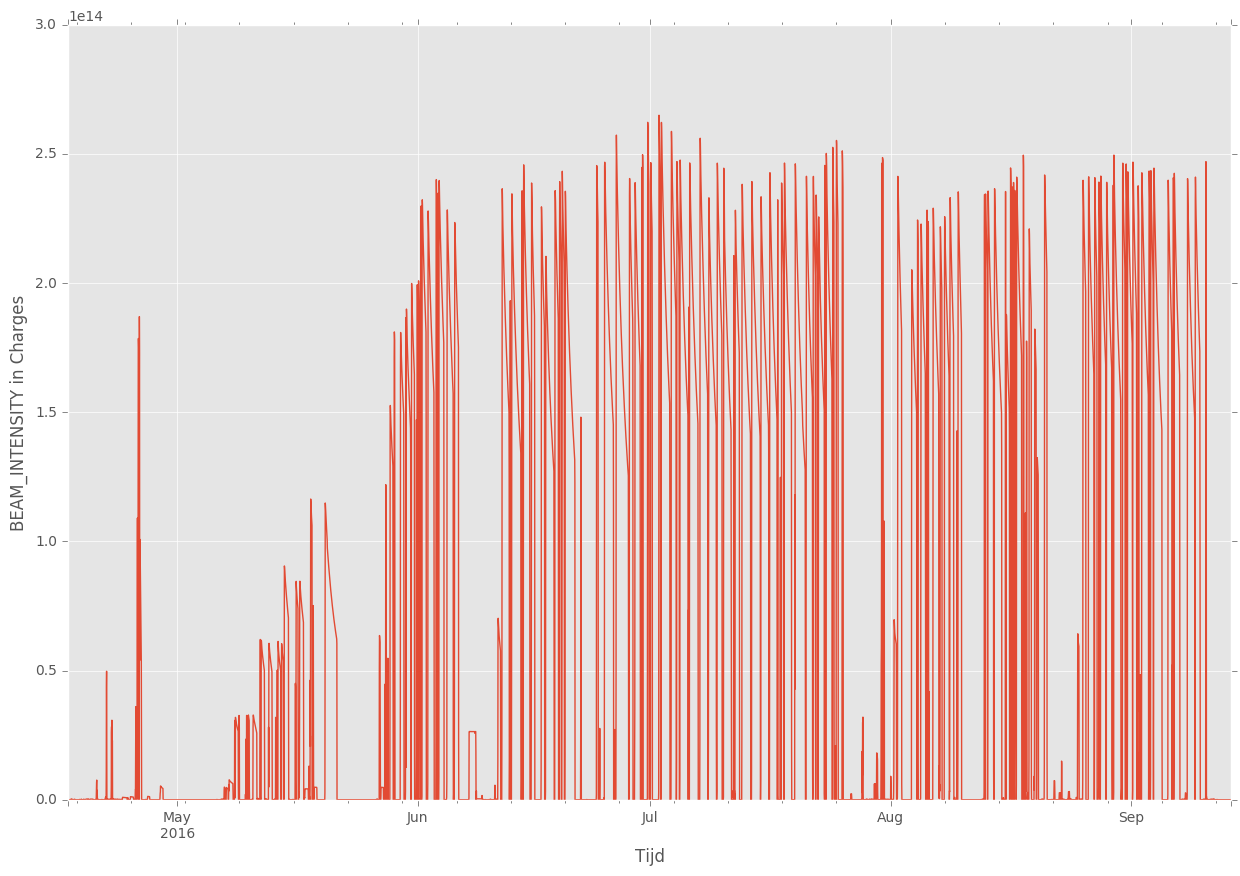

In [19]:
ax = intensity.plot(figsize=(15, 10), legend=False)
ax.set_xlabel("Tijd")
ax.set_ylabel("BEAM_INTENSITY in Charges")

## Supervised

In [49]:
# label the data
labels_B1 = ELB_B1[ELB_B1['TAG']== 'anomaly']
B1_30_s_supervised = B1_30_s.copy()
B1_30_s_supervised['anomaly'] = 0
for anom_ts in labels_B1.index:
    start = anom_ts - pd.Timedelta(12, unit='h')
    B1_30_s_supervised.loc[start:anom_ts, 'anomaly'] = 1

In [50]:
from sklearn.ensemble import RandomForestClassifier
training = B1_30_s_supervised.loc[:'2016-08-03 18:00:00']
test = B1_30_s_supervised.loc['2016-08-03 18:00:00': ]
display('Training set size: {}'.format(training.shape[0])) 
display('Test set size: {}'.format(test.shape[0]))
display('Labels in training: {}'.format(labels_B1.loc[:'2016-08-03 18:00:00'].shape[0]))
display('Labels in test: {}'.format(labels_B1.loc['2016-08-03 18:00:00':].shape[0]))

train_features = training.ix[:, ~B1_30_s_supervised.columns.isin(['log_prob', 'anomaly'])]
train_labels = training['anomaly']
test_features = test.ix[:, ~B1_30_s_supervised.columns.isin(['log_prob', 'anomaly'])]
test_labels = test['anomaly']

'Training set size: 31954'

'Test set size: 13768'

'Labels in training: 7'

'Labels in test: 2'

In [51]:
clf = RandomForestClassifier(class_weight='balanced').fit(train_features, train_labels)
predictions = clf.predict(test_features)

In [52]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
display(precision_recall_fscore_support(test_labels, predictions))
display(confusion_matrix(test_labels, predictions, labels=[1, 0]))

(array([ 0.95162359,  0.01604278]),
 array([ 0.98596277,  0.00454545]),
 array([ 0.96848889,  0.00708383]),
 array([13108,   660]))

array([[    3,   657],
       [  184, 12924]])

In [53]:
test_features = test_features.copy()
test_features['prediction'] = predictions
# for segmentation later
test_features['log_prob'] = 0
detected = test_features[test_features['prediction'] == 1]
detected_w_label, labeled_w_detected = evaluation.compare_detected_w_labeled(detected, labels_B1)
display(labeled_w_detected)

nb_detected
timestamps                      
2016-06-19 13:14:00            0
2016-06-30 21:23:00            0
2016-07-24 22:19:48            0
2016-07-31 16:00:00            0
2016-08-02 17:28:00            0
2016-08-02 17:50:00            0
2016-08-03 08:05:00            0
2016-08-04 14:03:41            3
2016-08-23 06:53:47            0

In [54]:
supervised_segmenter = evaluation.AnomalySegmenter()
segments = supervised_segmenter.create_segments(detected)

In [57]:
def plot_segments_series(data, series_name, unit, segments, labels=None):
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), sharex=True)
    regex = '^MKI.*:%s$' % series_name
    timeseries = data.filter(regex=regex)
    timeseries.plot(ax=ax1, colormap='winter', kind='line', linestyle='solid')

    ax2_title = "Detected segments"
    if labels is not None:
        for label in labels.index:
            ax2.axvline(label, ymin=0, ymax=0.3, color='green')
        ax2_title = "Gedetecteerde segmenten (rood) en labels (groen)"

    segment_centers = [segment.get_mean_ts() for segment in segments]
    X = -1 * np.array([segment.get_nb_anomalies() for segment in segments])
    X_std = (X - X.min()) / (X.max() - X.min())
    segment_scores = X_std * (1 - 0.31) + 0.31
    for center, score in zip(segment_centers, segment_scores):
        plt.axvline(center, ymin=0.3, ymax=score, color='red')
        # plt.text(center, 1, score, rotation='vertical')
    ax1.set_title(series_name)
    ax1.set_ylabel(u"{0} in {1}".format(series_name, unit))
    ax2.yaxis.set_visible(False)
    ax2.set_title(ax2_title)

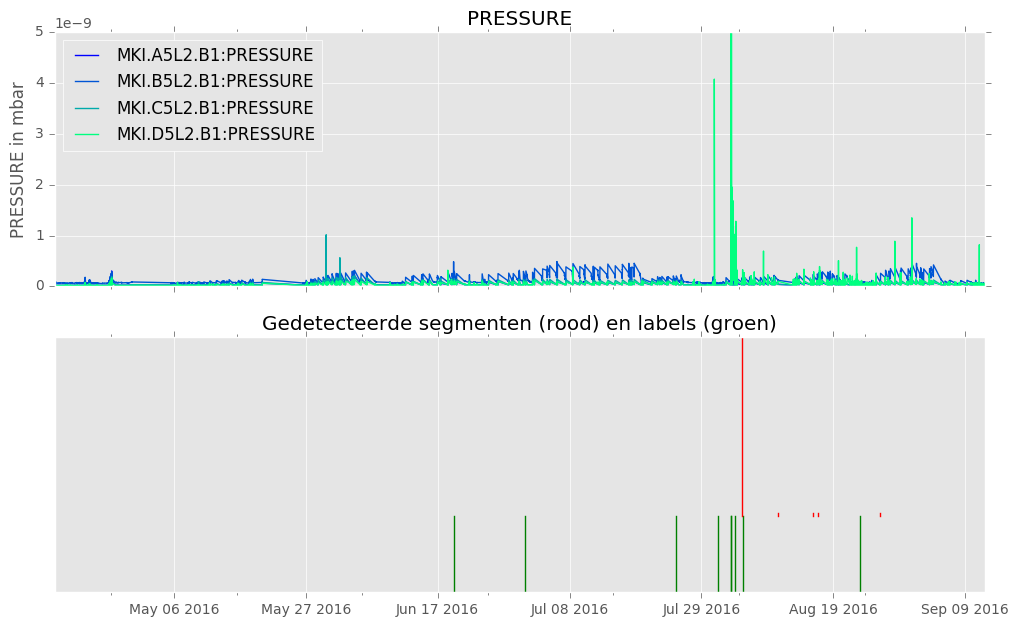

In [59]:
plot_segments_series(B1_30, "PRESSURE", "mbar", segments, labels_B1)